Training set shape: (614, 12)
Test set shape: (154, 12)
Training set shape after SMOTE: (802, 12)
Class distribution after SMOTE: Outcome
0    401
1    401
Name: count, dtype: int64


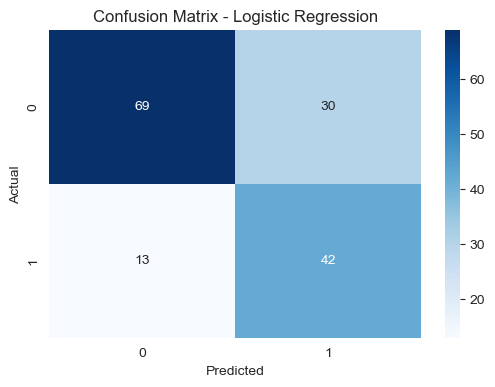

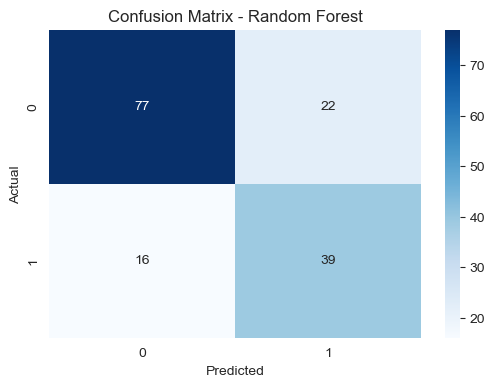

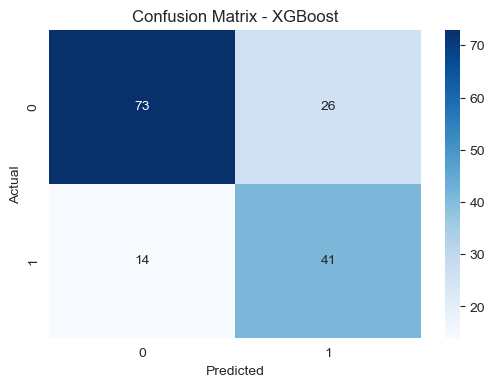


Model Performance:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.720779   0.583333  0.763636  0.661417  0.824793
1        Random Forest  0.753247   0.639344  0.709091  0.672414  0.831497
2              XGBoost  0.740260   0.611940  0.745455  0.672131  0.802938


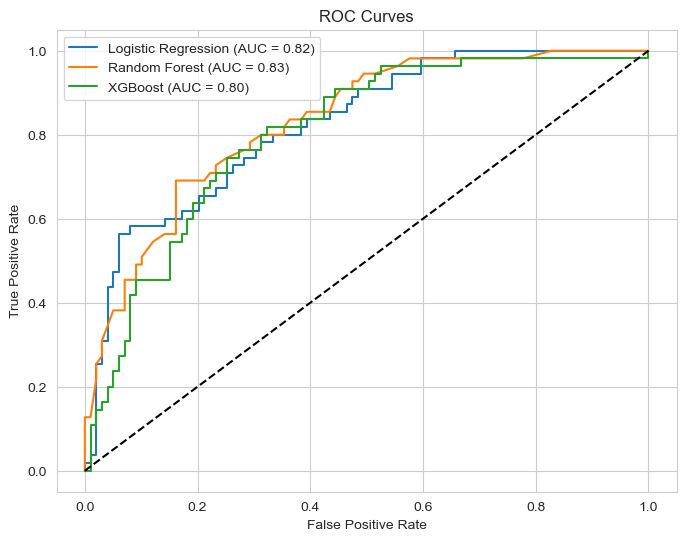


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest F1-Score: 0.6885245901639344

Feature Importance (Random Forest):
                     Feature  Importance
1                    Glucose    0.196889
8      Glucose_Insulin_Ratio    0.151284
7                        Age    0.142110
5                        BMI    0.118468
6   DiabetesPedigreeFunction    0.087148
0                Pregnancies    0.063508
4                    Insulin    0.062001
3              SkinThickness    0.057459
2              BloodPressure    0.057374
11        BMI_Category_Obese    0.043217
9        BMI_Category_Normal    0.012026
10   BMI_Category_Overweight    0.008517


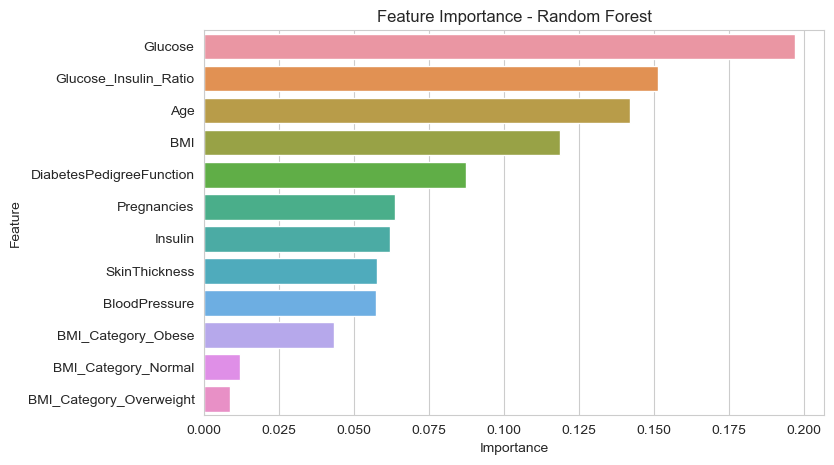

Best Random Forest model saved as best_rf_model.pkl


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
file_path = r'C:\Users\vivek\Data science projects\Data-Science-Project-Portfolio\DIABETES\data\processed_diabetes.csv'
df_clean = pd.read_csv(file_path)

# features and target
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

# handleclass imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print('Training set shape after SMOTE:', X_train_sm.shape)
print('Class distribution after SMOTE:', pd.Series(y_train_sm).value_counts())

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

results_df = pd.DataFrame(results)
print('\nModel Performance:')
print(results_df)

# ROC Curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Best model results
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print('\nBest Random Forest Parameters:', grid_search.best_params_)
print('Best Random Forest F1-Score:', f1_score(y_test, y_pred_best))

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print('\nFeature Importance (Random Forest):')
print(feature_importance)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.show()

import joblib
joblib.dump(best_rf, 'best_rf_model.pkl')
print('Best Random Forest model saved as best_rf_model.pkl')

In [4]:
# adjusted threshold for Random Forest to prioritize recall
best_rf = joblib.load('best_rf_model.pkl')
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.4  # Lower threshold to increase recall
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate
print('\nRandom Forest with Adjusted Threshold (0.4):')
print('Recall:', recall_score(y_test, y_pred_adjusted))
print('F1-Score:', f1_score(y_test, y_pred_adjusted))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_adjusted))


Random Forest with Adjusted Threshold (0.4):
Recall: 0.8363636363636363
F1-Score: 0.6865671641791045
Confusion Matrix:
 [[66 33]
 [ 9 46]]
